<a href="https://colab.research.google.com/github/sanya29/ML-and-Data-Science-projects/blob/master/dog-vision-deep-learning/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶End-to-end Multiclass Dog Breed Classification

This notebook builds an end-to-end multiclass image classifier using Tensor Flow 2.0 and TensorFlow Hub.

## Problem 
Identifying the breed of a dog given an image of a dog.

## Data
The data used is from Kaggle's dog breed identification competition. It can be found at https://www.kaggle.com/c/dog-breed-identification/data

## Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best to use deep learning/ transfer learning.
* There are 120 breeds of dogs.
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images don't have labels)

In [0]:
#!unzip "drive/My Drive/Dog-Vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog-Vision/"

## Getting our workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [3]:
# Import necessary tools into Colab

import tensorflow as tf
import tensorflow_hub as hub

print("TF version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)

# Check for GPU availability 
print("GPU","available (yes!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version:  2.2.0
TF Hub version:  0.8.0
GPU available (yes!)


## Getting our data ready (turning it into Tensors)

Our data has to be in numerical format. So we must turn our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [4]:
# Checkout the labels of our data

import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog-Vision/labels.csv")

print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     3eb8ea8e80639a6df20fb8a5abe43bfe  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


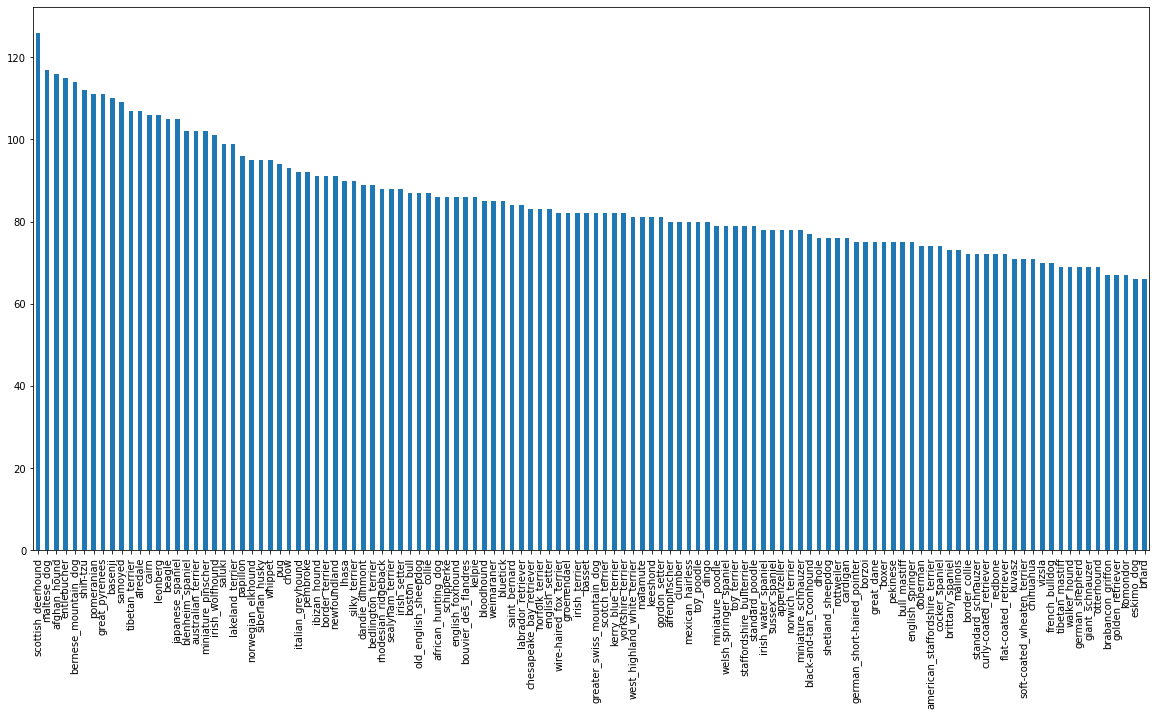

In [5]:
# How many images are there of each breed?

labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [6]:
labels_csv["breed"].value_counts().median()

82.0

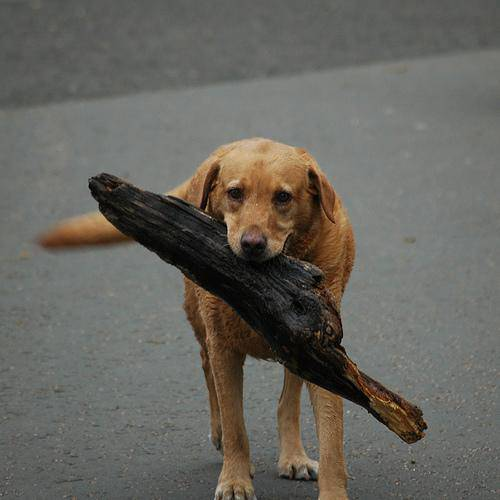

In [50]:
# Let's view an image

from IPython.display import Image

Image("drive/My Drive/Dog-Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

## Getting images and their labels

Let's get a list of all our image file pathnames

In [8]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog-Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog-Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog-Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog-Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog-Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog-Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog-Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog-Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog-Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog-Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog-Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog-Vision/train/")) == len(filenames):
  print("# filenames = # files")
else:
  print("# filenames != # files")

# filenames = # files


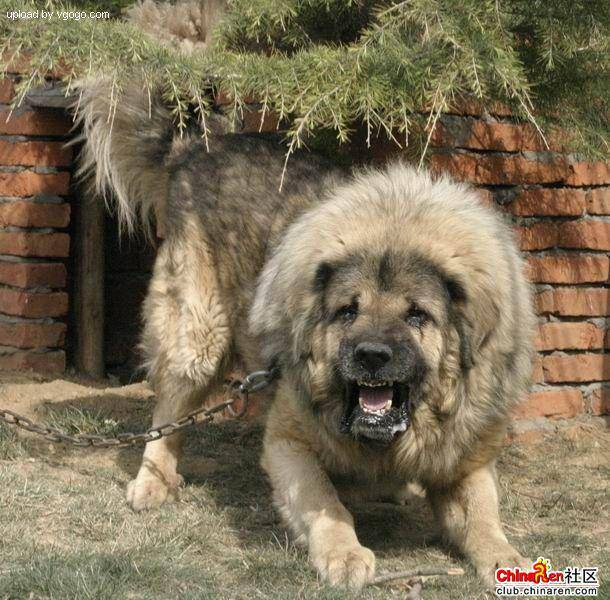

In [10]:
# One last check
Image(filenames[9000])

In [11]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [12]:
import numpy as np

labels = labels_csv["breed"].to_numpy() # labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
len(labels)

10222

In [14]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("You're good to go")
else:
  print("Recheck your work")

You're good to go


In [15]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [16]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [17]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [18]:
len(boolean_labels)

10222

In [19]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own

In [0]:
# Setup X: feature matrix, y: labels
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {type: "slider", min:1000, max:10000, step:1000}


In [22]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [23]:
# Let's have a gaze at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog-Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog-Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog-Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog-Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog-Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors, we're going to write a function that does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [24]:
# Convert an image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

(height, width, color channel)

In [25]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [26]:
image.min(), image.max()

(0, 255)

In [27]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now that we've seen what an image looks like as a Tensor, let's make a function to preprocess them

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """

  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32) 
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size = [img_size, img_size])

  return image

## Turning our data into batches

Why turn our data into batches? 

Let's say you're trying to process 10,000+ images in one go, they all might not fit into memory. So we try to stick to about 32 (this is the batch size) images at a time. We can manually adjust the batch size if need be.

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`

Basically, we pass 32 of these at a time.

In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, 
  processes the image and return s a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label


In [30]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches.

In [0]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  It shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  """

  # If the data is a test dataset, we don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch 

  # if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE);
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    
    # Shuffling pathnames and labels before mapping image processor function is faster
    # than shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [32]:
# Create training and validation batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [33]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

Our data is now in batches, however, these can be a little hard to understand/comprehend. Let's visualize them.

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize = (10,10))
  # Loop through 25
  for i in range(25):
    # Create subplots (5 row, 5 cols)
    ax = plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [35]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [36]:
train_images, train_labels = next(train_data.as_numpy_iterator())

len(train_images), len(train_labels)

(32, 32)

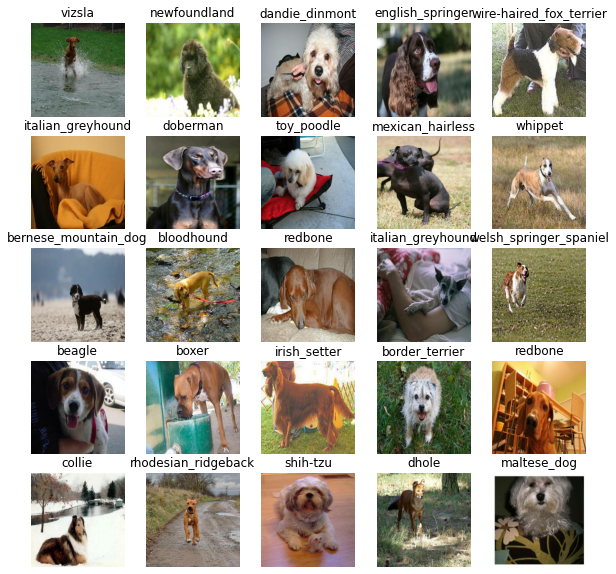

In [37]:
# Now let's visualize the data in a training batch

show_25_images(train_images, train_labels)

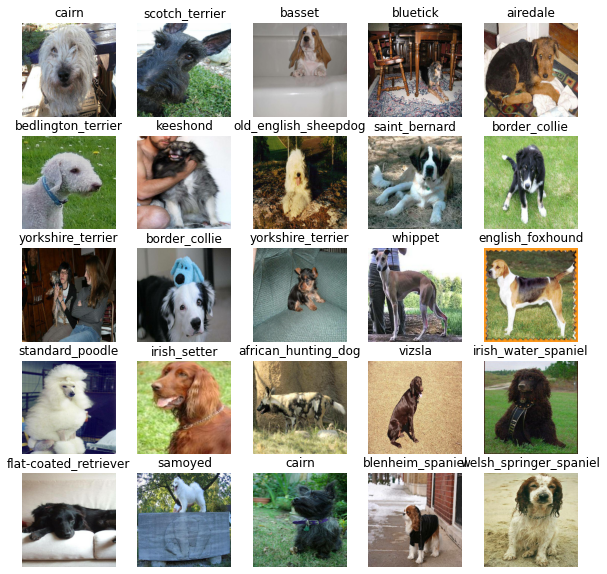

In [38]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we buid a model, there are a few things we need to define:
* The input shape (our images' shapes, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup the output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs, and model ready to go. Let's put them together into a Keras deep learning model! 

Knowing this, let's create a function that:
* Takes the input shape, output shape, and the model we've chosen as parameters
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [0]:
# Create a function that builds a Keras model

def create_model (input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with: ", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                                                     activation = "softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [41]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress, or stop training early if a model stop improving.

We'll create two callbacks: one for TensorBoard, which helps track our model's progress, and another for early stopping, which prevents our model from training for too long (and overfitting).


### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our model's training logs with the `%tensorboard` magic function (we'll do this after model training)

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog-Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment,
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max:100, step:10}

In [46]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function that trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model, passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data=val_data,
            validation_freq = 1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [48]:
# Fit the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 664s 27s/step - loss: 4.4794 - accuracy: 0.1112 - val_loss: 3.2188 - val_accuracy: 0.3200
Epoch 2/100
25/25 [==============================] - 6s 258ms/step - loss: 1.5663 - accuracy: 0.7038 - val_loss: 2.0839 - val_accuracy: 0.5500
Epoch 3/100
25/25 [==============================] - 6s 259ms/step - loss: 0.5468 - accuracy: 0.9362 - val_loss: 1.6504 - val_accuracy: 0.6450
Epoch 4/100
25/25 [==============================] - 6s 258ms/step - loss: 0.2473 - accuracy: 0.9912 - val_loss: 1.4930 - val_accuracy: 0.6700
Epoch 5/100
25/25 [==============================] - 7s 278ms/step - loss: 0.1426 - accuracy: 1.0000 - val_loss: 1.4229 - val_accuracy: 0.6650
Epoch 6/100
25/25 [==============================] - 6s 258ms/step - loss: 0.0981 - accuracy: 1.0000 - val_loss: 1.3671 - val_accuracy: 0.6750
Epoch 7/100
25/25 [=============================

It looks like our model is overfitting because it's performing far better on the training set than the validation set. So how do we prevent model overfitting in deep learning neural networks?

**Note** Overfitting to begin with is a good thing! It means our model is learning!

### Checking the TensorBoard Logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents

In [49]:
%tensorboard --logdir drive/My\ Drive/Dog-Vision/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [51]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 162ms/step


array([[9.9913299e-04, 2.3090292e-04, 4.8074304e-04, ..., 2.7744006e-04,
        9.1429931e-05, 2.0652025e-03],
       [9.0873829e-04, 7.9813195e-05, 6.4752600e-03, ..., 1.3869804e-04,
        5.0490128e-04, 1.0452891e-05],
       [1.0452481e-05, 1.3326760e-04, 4.2501206e-06, ..., 3.1443105e-05,
        6.9288420e-05, 2.3800266e-04],
       ...,
       [5.9673998e-06, 3.2576692e-05, 2.1804997e-05, ..., 8.7574581e-06,
        1.8765387e-04, 6.9181377e-05],
       [1.6481604e-03, 3.8295817e-05, 2.3584213e-05, ..., 6.4457417e-05,
        2.1055892e-04, 2.5824632e-03],
       [8.6469314e-04, 1.2942540e-04, 1.5722661e-03, ..., 1.1099746e-02,
        6.3687074e-03, 1.2157741e-04]], dtype=float32)

In [52]:
predictions.shape

(200, 120)

In [53]:
len(y_val)

200

In [54]:
len(unique_breeds)

120

In [55]:
predictions[0]

array([9.9913299e-04, 2.3090292e-04, 4.8074304e-04, 6.8522932e-05,
       4.6772294e-04, 3.8784838e-04, 7.8887651e-03, 1.6890448e-03,
       5.2800900e-05, 1.1797969e-03, 4.0028692e-04, 7.7089033e-04,
       1.2274681e-03, 3.9446590e-04, 1.2309644e-03, 1.4111098e-03,
       6.8249465e-05, 2.3454316e-01, 1.1921441e-05, 5.3383115e-05,
       5.9021893e-04, 9.1710384e-04, 1.3707932e-04, 2.4579337e-03,
       1.3102699e-04, 1.7379473e-03, 2.0302878e-01, 1.2061358e-04,
       6.1499322e-04, 4.4419078e-04, 1.6025797e-04, 2.3154330e-03,
       2.6756576e-03, 2.0330990e-04, 8.4427034e-04, 4.4930529e-02,
       2.5580155e-05, 1.0341533e-03, 8.9903311e-05, 5.2237714e-04,
       2.4227977e-03, 2.8502727e-05, 5.6150788e-04, 1.9808093e-04,
       6.6515226e-05, 8.1055827e-04, 3.5647372e-05, 1.4421465e-05,
       7.9133402e-05, 1.8287564e-04, 5.2052521e-04, 1.8786881e-04,
       6.3415518e-04, 7.8651799e-05, 2.6548344e-03, 8.1055899e-05,
       8.3639017e-05, 5.5199466e-03, 2.5281631e-03, 6.2418386e

In [56]:
np.sum(predictions[0])

1.0

In [58]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted labels: {unique_breeds[np.argmax(predictions[index])]}")

[2.43983341e-05 7.26532016e-05 2.65419912e-05 4.47305101e-05
 1.47941825e-03 3.16897458e-05 2.36646956e-04 1.49131357e-03
 1.70086604e-02 1.26859304e-02 3.10456489e-05 1.69878276e-05
 6.88396918e-04 4.63271094e-03 5.00538968e-04 1.10076051e-02
 3.01308773e-05 4.71079082e-04 1.93692948e-04 1.32771046e-03
 2.33594237e-05 6.94790331e-04 8.14777595e-05 1.01545680e-04
 6.68444298e-03 3.79340272e-05 1.61848831e-04 2.50894984e-04
 1.37226438e-04 2.10408416e-05 3.60570921e-05 2.69552384e-05
 4.29251595e-05 2.07124212e-05 2.15675409e-05 4.27043851e-05
 3.66372929e-04 5.11242717e-04 3.62088795e-05 1.33229315e-01
 4.64931509e-04 1.51057593e-05 4.30319551e-03 1.75839032e-05
 7.23051780e-05 2.38700395e-05 3.70397756e-05 5.19358495e-04
 1.84466753e-05 1.25738472e-04 4.09190216e-05 6.96646384e-05
 2.32049439e-04 2.47340300e-03 4.68365979e-05 1.13498558e-04
 2.65904586e-04 6.00159183e-05 2.56779400e-04 9.67048800e-06
 1.53601104e-05 5.93777455e-04 6.45914542e-06 8.60480650e-05
 1.22925951e-04 9.981692

Having the above functionality is great, but we want to be able to do it at scale. 

It would be even better if we could see the image the prediction is being made on.

**Note:** Prediction probabilities are also known as confidence levels.

In [59]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'brittany_spaniel'

In [60]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Now since our validation data is still in a batch dataset, we'll have to unbatch-ify it to make predictions on the validation images, and then compare those predictions to the valiation labels (truth labels)

In [92]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* prediction labels
* validation labels (truth labels)
* validation images

Let's make some functions to make these all a bit more visual

We'll create a function that:
* Takes an array of prediciton probabilities, truth labels, and images and an integer
* Convert the prediction probabilities to a predicted labels
* Plot the predicted label, its predicted probability, the truth label, and the target image on a single plot

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

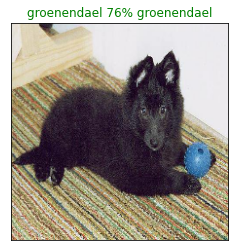

In [96]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our model's top prediction, let's make another to view our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the predicted label using `get_pred_label` 
* Find the top 10:
  * prediction probabilities indices
  * prediction probabilities values
  * prediction labels
* Plot the top 10 prediction probability values and labels, colouring the true label green

In [0]:

def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

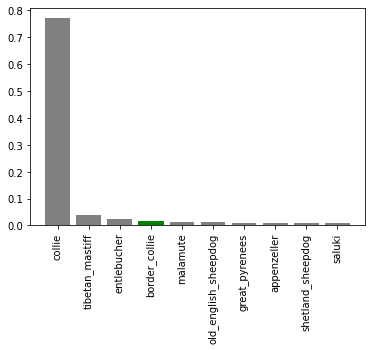

In [98]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

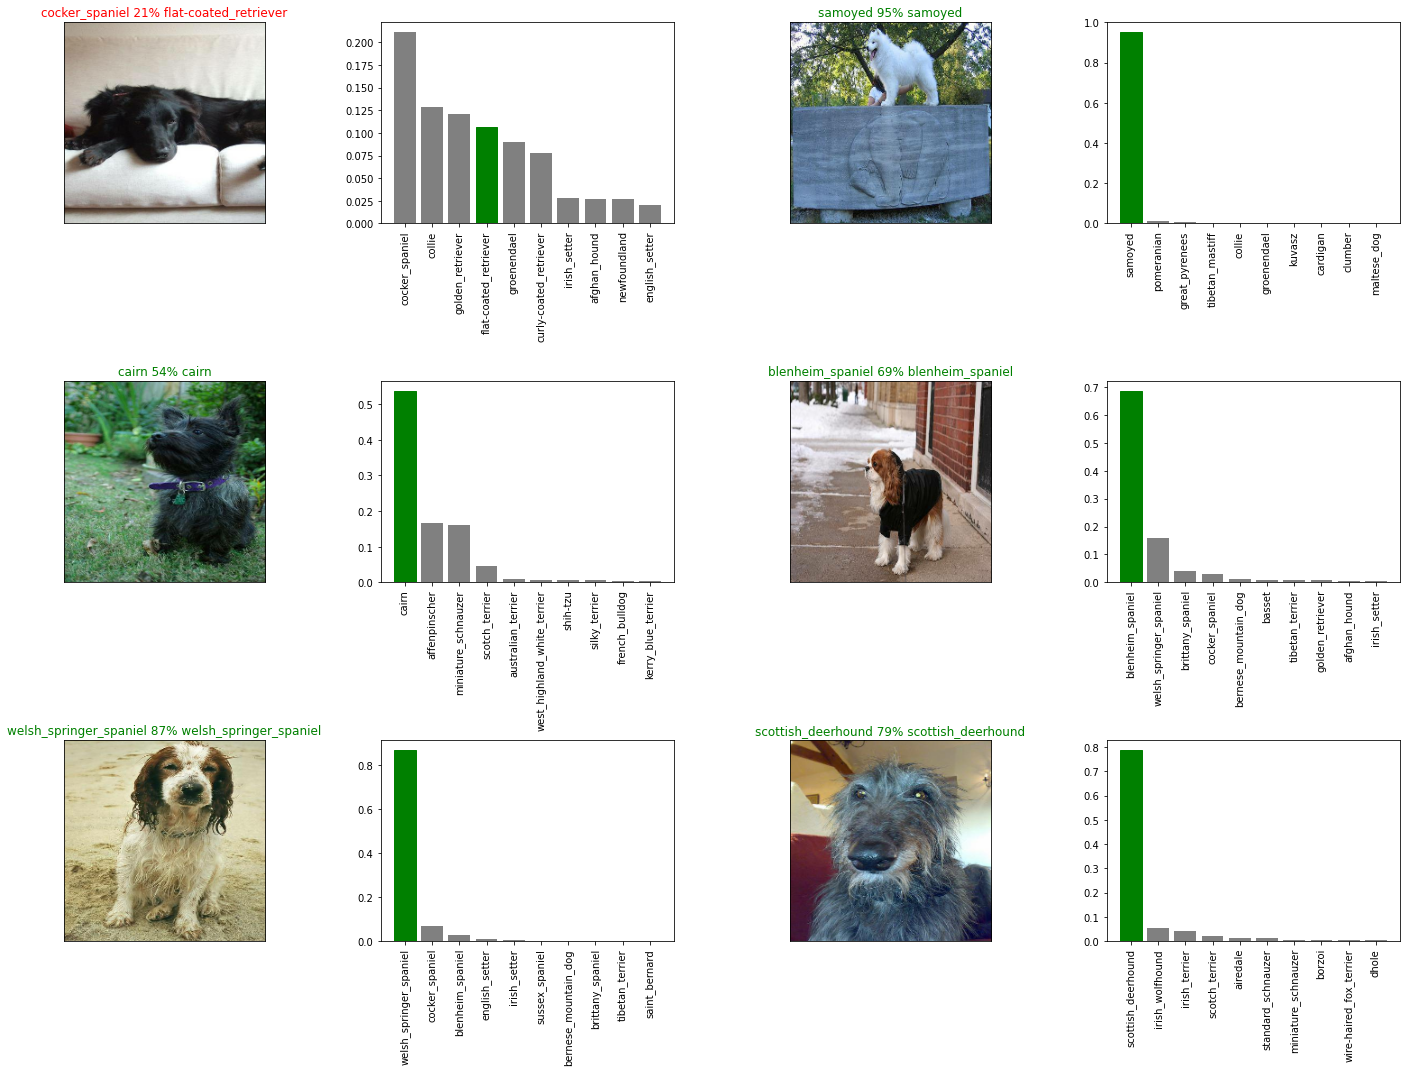

In [99]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [0]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog-Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [0]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've created functions to save and load models, let's see if they work!

In [108]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog-Vision/models/20200615-15091592233791-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog-Vision/models/20200615-15091592233791-1000-images-mobilenetv2-Adam.h5'

In [111]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog-Vision/models/20200615-15091592233791-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog-Vision/models/20200615-15091592233791-1000-images-mobilenetv2-Adam.h5


In [112]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 153ms/step - loss: 1.2489 - accuracy: 0.6950


[1.2489198446273804, 0.6949999928474426]

In [113]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 171ms/step - loss: 1.2489 - accuracy: 0.6950


[1.2489198446273804, 0.6949999928474426]

## Training a big dog model 🐶 (on the full data)

In [114]:
len(X), len(y)

(10222, 10222)

In [115]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creating training data batches...


In [116]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [117]:
# Create a model for full model
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# There's no validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [119]:
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 7577s 24s/step - loss: 1.3266 - accuracy: 0.6740
Epoch 2/100
320/320 [==============================] - 66s 205ms/step - loss: 0.4028 - accuracy: 0.8828
Epoch 3/100
320/320 [==============================] - 67s 208ms/step - loss: 0.2374 - accuracy: 0.9356
Epoch 4/100
320/320 [==============================] - 66s 205ms/step - loss: 0.1545 - accuracy: 0.9646
Epoch 5/100
320/320 [==============================] - 66s 207ms/step - loss: 0.1047 - accuracy: 0.9797
Epoch 6/100
320/320 [==============================] - 65s 203ms/step - loss: 0.0783 - accuracy: 0.9862
Epoch 7/100
320/320 [==============================] - 66s 205ms/step - loss: 0.0584 - accuracy: 0.9915
Epoch 8/100
320/320 [==============================] - 66s 207ms/step - loss: 0.0462 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 66s 206ms/step - loss: 0.0380 - accuracy: 0.9948
Epoch 10/100
320/320 [==============================] - 65s 204m

In [120]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog-Vision/models/20200615-18101592244638-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog-Vision/models/20200615-18101592244638-full-image-set-mobilenetv2-Adam.h5'

In [122]:
# Load in the full model
loaded_full_model = load_model('/content/drive/My Drive/Dog-Vision/models/20200615-18101592244638-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/My Drive/Dog-Vision/models/20200615-18101592244638-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created create_data_batches() earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames. 
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since the test data doesn't have labels). 
* Make a predictions array by passing the test batches to the predict() method called on our model.

In [123]:
# Load test image filenames
test_path = "drive/My Drive/Dog-Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog-Vision/test/ec7eab1c7a2275c89f2d3eca6e4afea2.jpg',
 'drive/My Drive/Dog-Vision/test/f11d26a12282ee91bfe37f22d7acd483.jpg',
 'drive/My Drive/Dog-Vision/test/eb2e408930e0873deb85484ef46f07fd.jpg',
 'drive/My Drive/Dog-Vision/test/ea6005562757cf5a7a37d70134d28870.jpg',
 'drive/My Drive/Dog-Vision/test/e83f4c0ff6dec86d89d0f8b70ecd3cea.jpg',
 'drive/My Drive/Dog-Vision/test/eb9aebedf9ed7d768a5afb36cd0e2436.jpg',
 'drive/My Drive/Dog-Vision/test/f586cdd98e69c6909b8048d728937ab9.jpg',
 'drive/My Drive/Dog-Vision/test/f080ee2429dccf56d2693fb8d3235010.jpg',
 'drive/My Drive/Dog-Vision/test/f11821f2a5777c36a4081588fb96798f.jpg',
 'drive/My Drive/Dog-Vision/test/eefac34d2a315aba5b14665c9b498b1d.jpg']

In [125]:
len(test_filenames)

10191

In [126]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [127]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling predict() on our full model and passing it the test data batch will take a long time to run (about ~2 hours). This is because we have to process ~10,000+ images and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [128]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

319/319 [==============================] - 8084s 25s/step


In [0]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog-Vision/preds_array.csv", test_predictions, delimiter=",")

In [0]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog-Vision/preds_array.csv", delimiter=",")

In [133]:
test_predictions[:10]

array([[3.75478493e-08, 1.25244515e-09, 5.96965644e-10, ...,
        3.99323297e-10, 3.65902082e-07, 1.82207032e-06],
       [4.70129287e-08, 4.34426894e-09, 1.65520468e-08, ...,
        3.87011869e-06, 2.77719125e-02, 5.64837023e-07],
       [6.13000717e-09, 4.56233634e-10, 2.93243204e-07, ...,
        5.96846128e-09, 2.25858386e-07, 6.57625606e-07],
       ...,
       [4.07591544e-10, 1.27400253e-05, 1.88494309e-09, ...,
        5.00165479e-05, 2.05277684e-05, 1.11564369e-10],
       [1.77093864e-06, 9.78204739e-11, 1.59739477e-09, ...,
        8.31545677e-09, 1.71479098e-09, 9.01865604e-08],
       [1.08844276e-08, 2.01927555e-11, 9.61411506e-11, ...,
        5.33468274e-08, 1.09735947e-06, 1.38360906e-10]])

In [134]:
test_predictions.shape

(10191, 120)

## Preparing test dataset predictions for Kaggle
Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [135]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [137]:
preds_df.head()

id  ... yorkshire_terrier
0  ec7eab1c7a2275c89f2d3eca6e4afea2  ...               NaN
1  f11d26a12282ee91bfe37f22d7acd483  ...               NaN
2  eb2e408930e0873deb85484ef46f07fd  ...               NaN
3  ea6005562757cf5a7a37d70134d28870  ...               NaN
4  e83f4c0ff6dec86d89d0f8b70ecd3cea  ...               NaN

[5 rows x 121 columns]

In [138]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  ec7eab1c7a2275c89f2d3eca6e4afea2  ...       1.82207e-06
1  f11d26a12282ee91bfe37f22d7acd483  ...       5.64837e-07
2  eb2e408930e0873deb85484ef46f07fd  ...       6.57626e-07
3  ea6005562757cf5a7a37d70134d28870  ...       2.23324e-08
4  e83f4c0ff6dec86d89d0f8b70ecd3cea  ...         8.748e-08

[5 rows x 121 columns]

In [0]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog-Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)


## Making predictions on custom images

To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [0]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog-Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [141]:
custom_image_paths

['drive/My Drive/Dog-Vision/my-dog-photos/dog-3.jpg',
 'drive/My Drive/Dog-Vision/my-dog-photos/dog-1.jpg',
 'drive/My Drive/Dog-Vision/my-dog-photos/dog-2.jpg']

In [142]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [144]:
custom_preds.shape

(3, 120)

In [145]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['lakeland_terrier', 'golden_retriever', 'golden_retriever']

In [0]:
# Get custom images (our unbatchify() function won't work since there aren't labels... fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

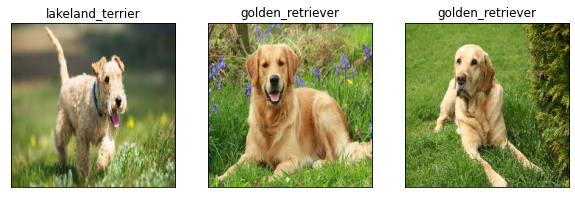

In [147]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)